In [1]:
import torch
import numpy as np
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from load_LIDC_data import LIDC_IDRI
from probabilistic_unet import ProbabilisticUnet
from utils import l2_regularisation

torch.cuda.set_device(1)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
dataset = LIDC_IDRI(dataset_location = '/data01/tima/')
dataset_size = len(dataset)
indices = list(range(dataset_size))
split = int(np.floor(0.1 * dataset_size))
np.random.shuffle(indices)
train_indices, test_indices = indices[split:], indices[:split]
train_sampler = SubsetRandomSampler(train_indices)
test_sampler = SubsetRandomSampler(test_indices)
train_loader = DataLoader(dataset, batch_size=5, sampler=train_sampler)
test_loader = DataLoader(dataset, batch_size=1, sampler=test_sampler)
print("Number of training/test patches:", (len(train_indices),len(test_indices)))

Loading file data_lidc.pickle
Number of training/test patches: (13587, 1509)


In [3]:
net = ProbabilisticUnet(input_channels=1, num_classes=1, num_filters=[32,64,128,192], latent_dim=2, no_convs_fcomb=4, beta=10.0)
net.to(device)
optimizer = torch.optim.Adam(net.parameters(), lr=1e-5, weight_decay=0)


In [5]:
for epoch in range(3):
    print("Epoch #" + str(epoch+1))
    running_loss = 0.0
    for step, (patch, mask, _) in enumerate(train_loader): 
        patch = patch.to(device)
        mask = mask.to(device)
        mask = torch.unsqueeze(mask,1)
        net.forward(patch, mask, training=True)
        elbo = net.elbo(mask)
        reg_loss = l2_regularisation(net.posterior) + l2_regularisation(net.prior) + l2_regularisation(net.fcomb.layers)
        loss = -elbo + 1e-5 * reg_loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
        if running_loss != running_loss: #checking nan
            break
        
        torch.save({
            'net': net,
            'optimizer': optimizer.state_dict(),
            'epoch':epoch,
            }, "/home/temirlan_aman/github/Probabilistic-Unet-Pytorch/checkpoint.pt")
        
        if step % 100 == 99:    # print every 100 mini-batches
            print('loss: %.3f'%(running_loss / 100))
            running_loss = 0.0
print("Finished training")

Epoch #1


/home/temirlan_aman/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


loss: 30116.483
loss: 4558.355
loss: 3442.021
loss: 3172.099
loss: 3084.930
loss: 2791.797
loss: 2466.064
loss: 2309.663
loss: 2389.347
loss: 2058.194
loss: 1830.985
loss: 1888.063
loss: 1752.580
loss: 1733.905
loss: 1367.384
loss: 1593.951
loss: 1426.342
loss: 1379.692
loss: 1197.202
loss: 960.406
loss: 1107.759
loss: 897.438
loss: 821.268
loss: 727.576
loss: 722.081
loss: 879.269
loss: 767.678
Epoch #2
loss: 851.326
loss: 750.407
loss: 737.352
loss: 704.594
loss: 708.075
loss: 631.135
loss: 721.982
loss: 663.045
loss: 910.581
loss: 628.295
loss: 673.436
loss: 759.481
loss: 743.773
loss: 584.566
loss: 646.277
loss: 597.397
loss: 636.845
loss: 631.064
loss: 540.313
loss: 629.125
loss: 689.508
loss: 602.761
loss: 585.140
loss: 569.273
loss: 721.564
loss: 596.251
loss: 676.731
Epoch #3
loss: 647.998
loss: 508.923
loss: 563.068
loss: 577.826
loss: 630.103
loss: 528.131
loss: 573.088
loss: 693.148
loss: 580.325
loss: 621.174
loss: 486.609
loss: 465.443
loss: 513.416
loss: 577.080
loss: 549

In [57]:
def jaccard(im1, im2):
    """
    Computes the Jaccard metric, a measure of set similarity.
    Parameters
    ----------
    im1 : array-like, bool
        Any array of arbitrary size. If not boolean, will be converted.
    im2 : array-like, bool
        Any other array of identical size. If not boolean, will be converted.
    Returns
    -------
    jaccard : float
        Jaccard metric returned is a float on range [0,1].
        Maximum similarity = 1
        No similarity = 0
    
    Notes
    -----
    The order of inputs for `jaccard` is irrelevant. The result will be
    identical if `im1` and `im2` are switched.
    """
    im1 = np.asarray(im1).astype(np.bool)
    im2 = np.asarray(im2).astype(np.bool)

    if im1.shape != im2.shape:
        raise ValueError("Shape mismatch: im1 and im2 must have the same shape.")

    intersection = np.logical_and(im1, im2)

    union = np.logical_or(im1, im2)
    if union.sum == 0:
        return 1
    return intersection.sum() / float(union.sum())

/home/temirlan_aman/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


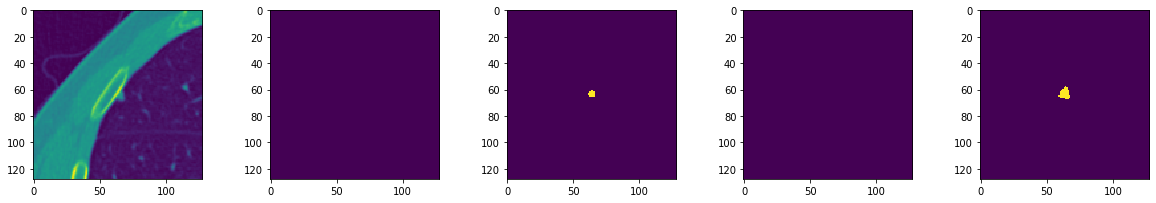

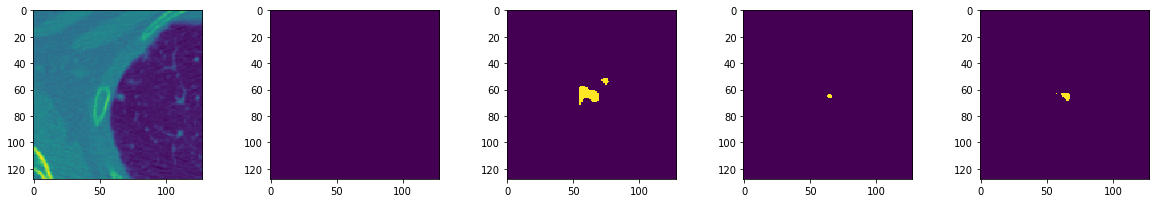

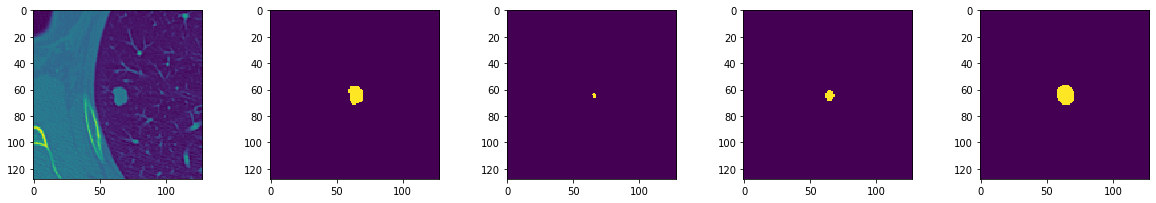

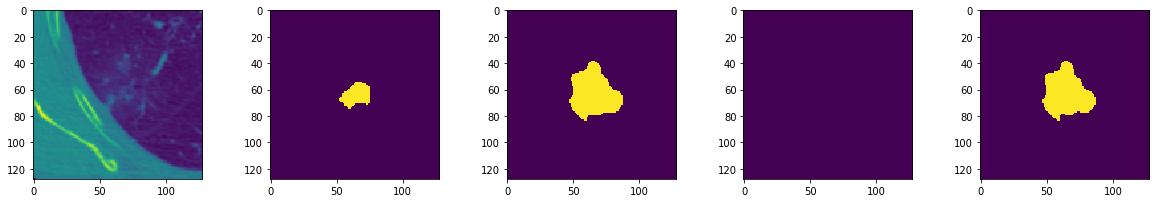

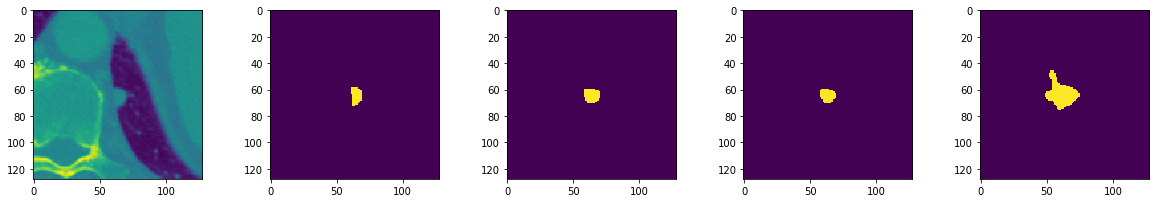

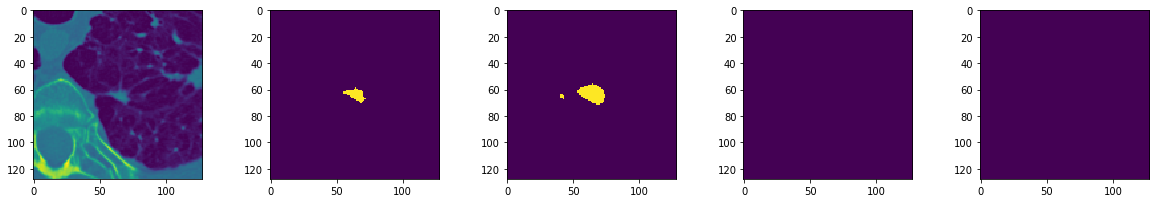

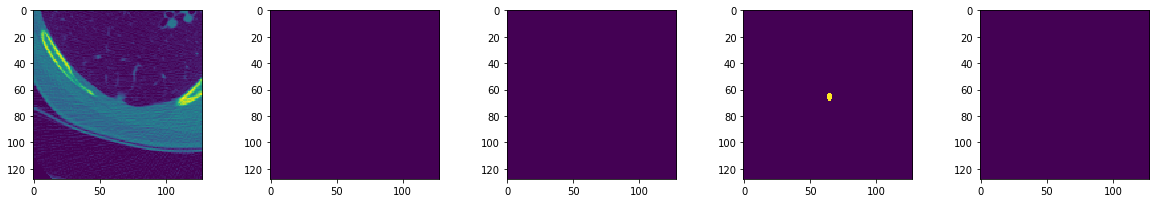

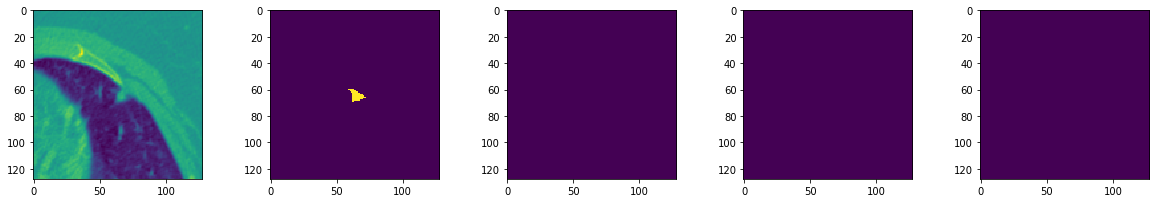

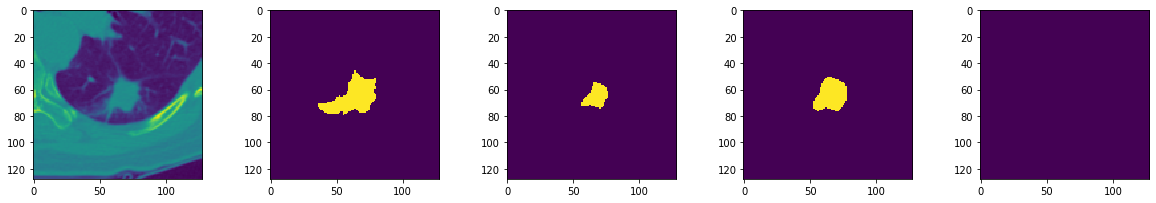

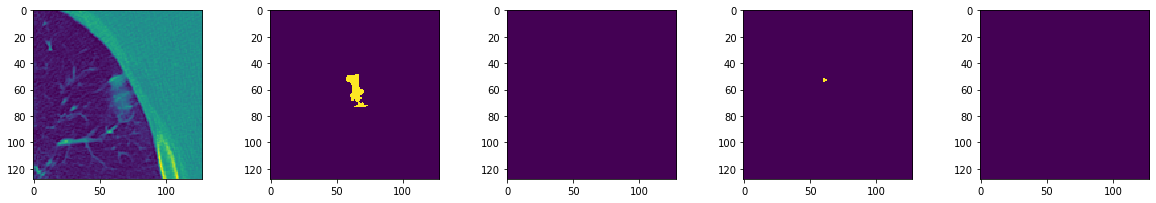

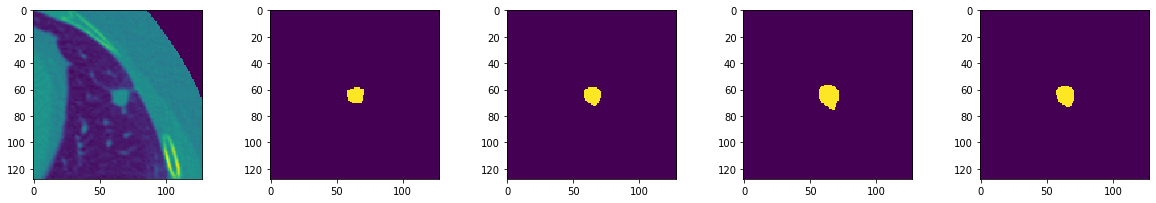

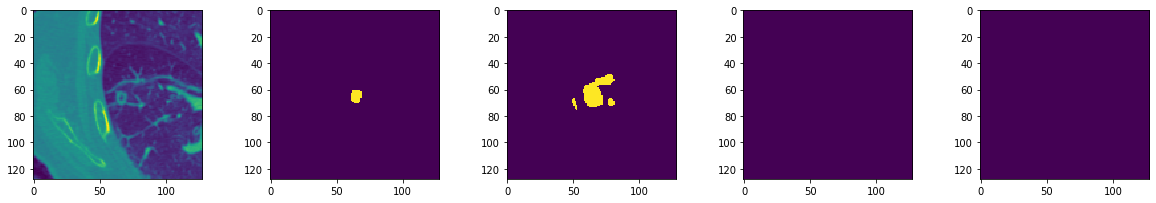

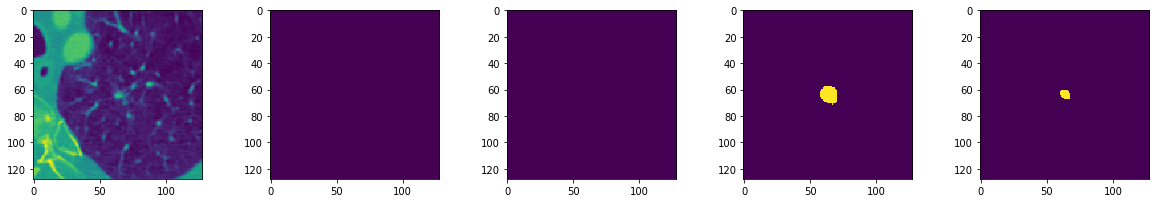

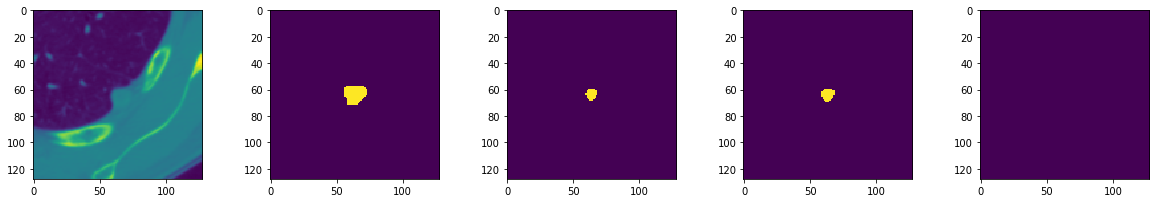

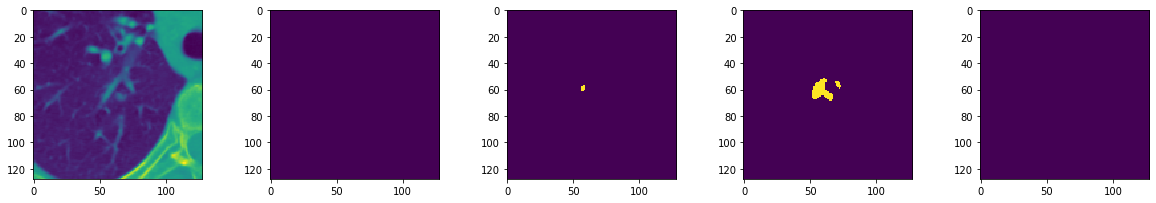

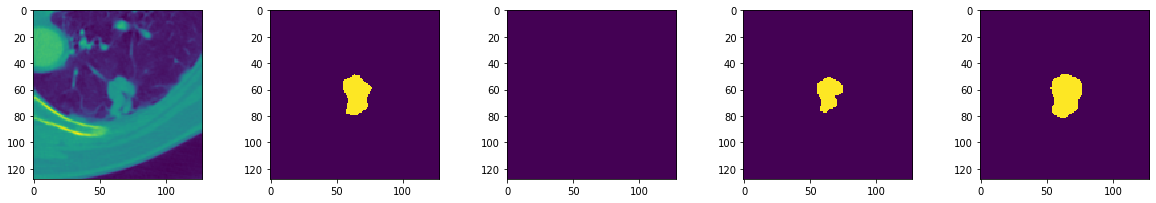

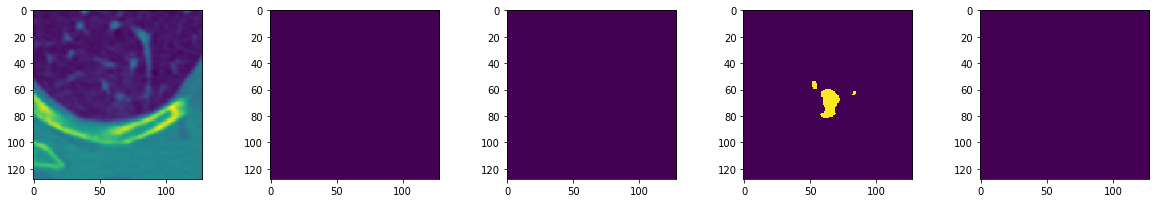

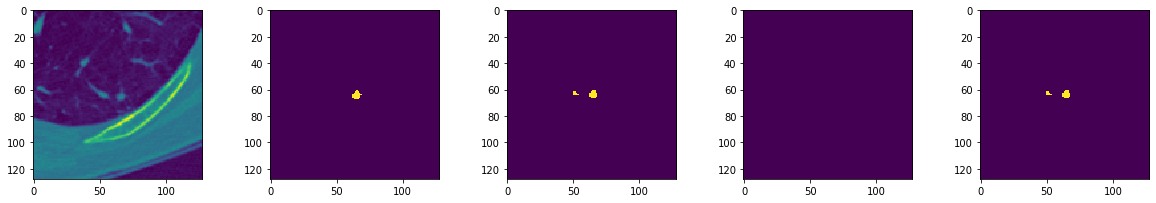

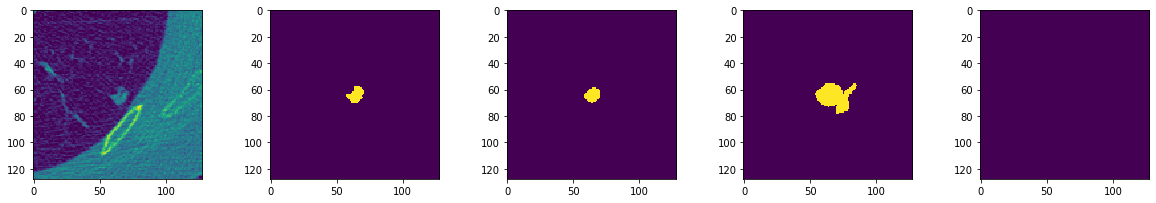

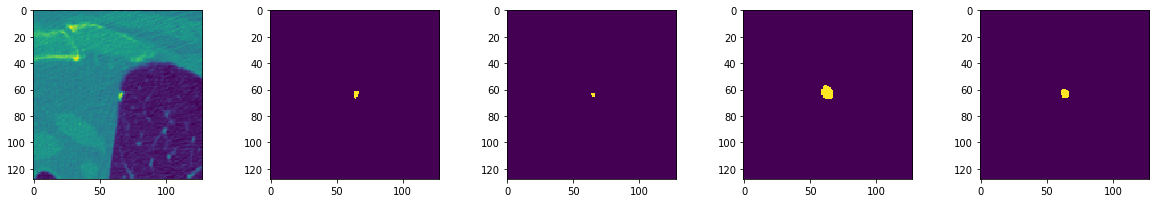

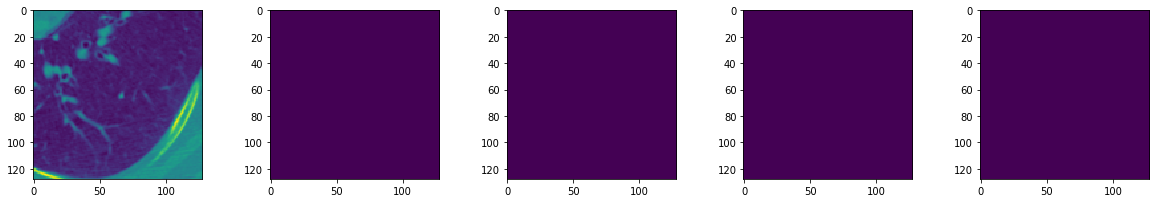

In [64]:
import matplotlib.pyplot as plt
import numpy
import PIL
x = 0
errors={}
print("")
for step, (patch, mask, _) in enumerate(train_loader):
    if x>20:
        break
    patch = patch.to(device)
    mask = mask.to(device)
    mask = torch.unsqueeze(mask,1)
    net.forward(patch, mask, training=False)
    predict1 = net.sample(testing = True)
    predict2 = net.sample(testing = True)
    predict3 = net.sample(testing = True)
    fig1 = plt.figure(figsize=(20, 20))
    fig1.subplots_adjust(hspace=0.4, wspace=0.4)
    ax = fig1.add_subplot(1, 5, 1)
    ax.imshow(patch[0,0,:,:].cpu().numpy())
    ax = fig1.add_subplot(1, 5, 2)
    ax.imshow(mask[0,0,:,:].cpu().numpy())
    ax = fig1.add_subplot(1, 5, 3)
    ax.imshow(predict1[0,0,:,:].detach().cpu().numpy()>0.5)
    ax = fig1.add_subplot(1, 5, 4)
    ax.imshow(predict2[0,0,:,:].detach().cpu().numpy()>0.5)
    ax = fig1.add_subplot(1, 5, 5) 
    ax.imshow(predict3[0,0,:,:].detach().cpu().numpy()>0.5)
    x+=1

In [51]:
errors


{}

In [47]:
fig1 = plt.figure()
    fig1.subplots_adjust(hspace=0.4, wspace=0.4)
    ay = fig1.add_subplot(1, 3, 3)
    ax = fig1.add_subplot(1, 2, 1)
    ax.imshow(patch[0,0,:,:].cpu().numpy())
    ax = fig1.add_subplot(1, 2, 2)
    ax.imshow(mask[0,0,:,:].cpu().numpy())
    fig2 = plt.figure()
    fig2.subplots_adjust(hspace=0.4, wspace=0.4)
    ay = fig2.add_subplot(1, 3, 1)
    ay.imshow(predict1[0,0,:,:].detach().cpu().numpy()>0.5)
    ay = fig2.add_subplot(1, 3, 2)
    ay.imshow(predict2[0,0,:,:].detach().cpu().numpy()>0.5)
    ay = fig2.add_subplot(1, 3, 3) 
    ay.imshow(predict3[0,0,:,:].detach().cpu().numpy()>0.5)

IndentationError: unexpected indent (<ipython-input-47-887d2fbaa872>, line 2)

In [ ]:
 print("Jaccard Index:",jaccard((predict1[0,0,:,:].detach().cpu().numpy()>0.5).reshape((128,128)),mask[0,0,:,:].cpu().numpy().reshape((128,128))))